In [1]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd

from collections import Iterable
import matplotlib.pylab as mpl

In [2]:
%load_ext autoreload

In [3]:
mat = sp.io.loadmat('allUnitsLog_claus.mat')
mat2 = sp.io.loadmat('Opto_log_allUnits_claus.mat')

In [4]:
log = mat['fullLog']
log_df = pd.DataFrame(log, columns=['mouse_name', 'date', 'block_type', 'trial_type', 'touch_stimulus',\
                                    'vis_stimulus', 'response','trial_num', 'stim_onset', 'stim_offset', 'licks_right',\
                                    'licks_left', 'spike_times', 'cluster_name' ])

log_df.head(2)

,mouse_name,date,block_type,trial_type,touch_stimulus,vis_stimulus,response,trial_num,stim_onset,stim_offset,licks_right,licks_left,spike_times,cluster_name
0,[Claustrum3],[03-16-17],[Visual],[Stim_Som_NoCue],[SineAmp0p925Freq20Cyc3],[Amp0p5Dur0p150],[[0]],[[[[3]]]],[[[[ 1.4482]]]],[[[[ 1.59566667]]]],[[[]]],[[[]]],"[[0.0117666666667], [0.0321666666667], [0.1104...",[TT1clst1]
1,[Claustrum3],[03-16-17],[Visual],[Stim_Som_NoCue],[SineAmp0p925Freq20Cyc3],[Amp0p5Dur0p150],[[0]],[[[[3]]]],[[[[ 1.4482]]]],[[[[ 1.59566667]]]],[[[]]],[[[]]],"[[0.155366666667], [0.355766666667], [1.549566...",[TT1clst2]


In [5]:
opto_log = mat2['fullOptoTable']
opto_log_df = pd.DataFrame(opto_log, columns=['mouse_name', 'date', 'cluster_name', 'opto_stim_onsets', 'opto_stim_offsets', 'spikes'])

opto_log_df.head(2)

,mouse_name,date,cluster_name,opto_stim_onsets,opto_stim_offsets,spikes
0,[Claustrum3],[03-16-17],[TT1clst1],"[[3964.30126667, 3964.80126667, 3965.30126667,...","[[3964.55126667, 3965.05126667, 3965.5513, 396...","[[3939.5548], [3939.7151], [3939.9379], [3940...."
1,[Claustrum3],[03-16-17],[TT1clst2],"[[3964.30126667, 3964.80126667, 3965.30126667,...","[[3964.55126667, 3965.05126667, 3965.5513, 396...","[[3939.7038], [3939.994], [3940.2059], [3940.5..."


In [6]:
for col in [0,1,2,3,4,5,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,11,11,13]:
        log_df.ix[:,col] = log_df.ix[:,col].str[0]
for col in [0,1,2,3,4]:
        opto_log_df.ix[:,col] = opto_log_df.ix[:,col].str[0]

In [7]:
log_df.head(2)

,mouse_name,date,block_type,trial_type,touch_stimulus,vis_stimulus,response,trial_num,stim_onset,stim_offset,licks_right,licks_left,spike_times,cluster_name
0,Claustrum3,03-16-17,Visual,Stim_Som_NoCue,SineAmp0p925Freq20Cyc3,Amp0p5Dur0p150,0,3,1.4482,1.595667,[],[],"[[0.0117666666667], [0.0321666666667], [0.1104...",TT1clst1
1,Claustrum3,03-16-17,Visual,Stim_Som_NoCue,SineAmp0p925Freq20Cyc3,Amp0p5Dur0p150,0,3,1.4482,1.595667,[],[],"[[0.155366666667], [0.355766666667], [1.549566...",TT1clst2


In [8]:
opto_log_df.head(2)

,mouse_name,date,cluster_name,opto_stim_onsets,opto_stim_offsets,spikes
0,Claustrum3,03-16-17,TT1clst1,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[[3939.5548], [3939.7151], [3939.9379], [3940...."
1,Claustrum3,03-16-17,TT1clst2,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[[3939.7038], [3939.994], [3940.2059], [3940.5..."


In [9]:
unique_sessions = opto_log_df[['mouse_name', 'date']].drop_duplicates()

opto_log_df['first_last_opto_pulses'] = np.nan
opto_log_df['grouped_opto_pulses'] = np.nan

for session in range(unique_sessions.shape[0]):
    session_row_ind = (opto_log_df.loc[:,['mouse_name', 'date']] == unique_sessions.iloc[session]).all(axis=1)
    rows = opto_log_df.loc[session_row_ind]
    
    ISIs = np.around(rows.iloc[0,3][1:]-rows.iloc[0,3][0:-1], 4)
    ISIs = np.concatenate(([ISIs[0]], ISIs, [ISIs[-1]]))
    unique_ISIs = np.unique(ISIs, return_counts = True)
    ind = unique_ISIs[1]>50
    unique_ISIs = unique_ISIs[0][ind]

    first_last_opto_pulses = {}
    grouped_opto_pulses = {}
    for isi in unique_ISIs:
        ISI_category = np.where(np.absolute(ISIs-isi) <= 0.001)[0]
        opto_pulse_inds= np.array(range(np.min(ISI_category),np.max(ISI_category)))
        grouped_opto_pulses[1/isi] = rows.iloc[0,3][opto_pulse_inds]

        IBI_ind = ISIs[opto_pulse_inds] != isi
        first_pulse_ind = np.concatenate(([opto_pulse_inds[0]],opto_pulse_inds[IBI_ind]))
        last_pulse_ind = np.concatenate((first_pulse_ind[1:]-1, [opto_pulse_inds[-1]]))
        first_last_opto_pulses[1/isi] = [rows.iloc[0,3][first_pulse_ind],rows.iloc[0,3][last_pulse_ind]]
    opto_log_df.loc[session_row_ind,'first_last_opto_pulses'] = [first_last_opto_pulses]
    opto_log_df.loc[session_row_ind,'grouped_opto_pulses'] = [grouped_opto_pulses]

In [10]:
opto_log_df.head(3)

,mouse_name,date,cluster_name,opto_stim_onsets,opto_stim_offsets,spikes,first_last_opto_pulses,grouped_opto_pulses
0,Claustrum3,03-16-17,TT1clst1,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[[3939.5548], [3939.7151], [3939.9379], [3940....","{40.0: [[4431.20513333, 4437.7807, 4444.389566...","{40.0: [4431.20513333, 4431.23013333, 4431.255..."
1,Claustrum3,03-16-17,TT1clst2,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[[3939.7038], [3939.994], [3940.2059], [3940.5...","{40.0: [[4431.20513333, 4437.7807, 4444.389566...","{40.0: [4431.20513333, 4431.23013333, 4431.255..."
2,Claustrum3,03-16-17,TT2clst1,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[[3939.6048], [3939.6874], [3939.7985], [3939....","{40.0: [[4431.20513333, 4437.7807, 4444.389566...","{40.0: [4431.20513333, 4431.23013333, 4431.255..."


C:\Users\Eric\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


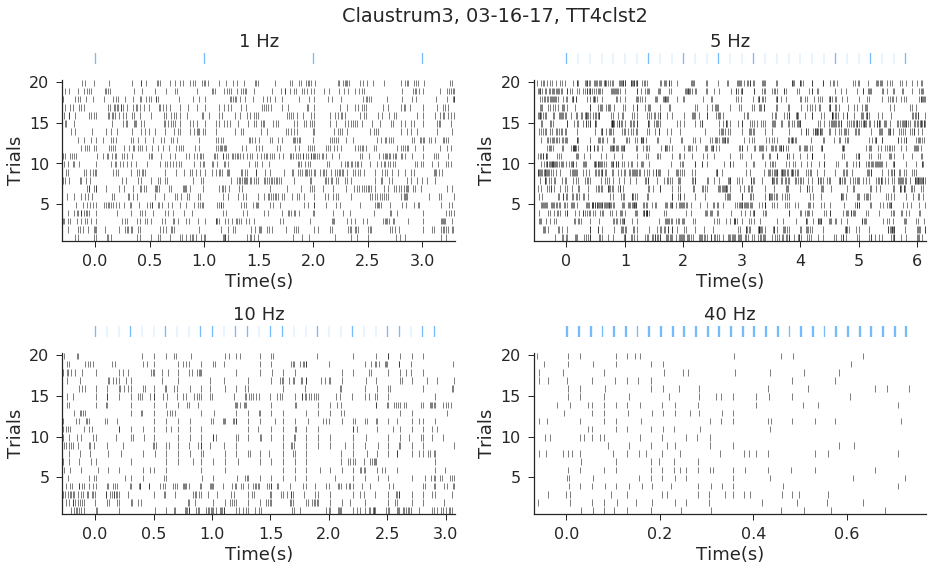

In [17]:
import matplotlib.patches as patches
from matplotlib import gridspec

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 

unit = opto_log_df.iloc[10]


mpl.close('all')
fig = mpl.figure(figsize=(15, 8))
fig.suptitle(unit['mouse_name'] + ', ' +  unit['date'] + ', ' + unit['cluster_name'])
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 15, 5, 1, 15]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[6])
ax4 = fig.add_subplot(gs[7])

rs1 = fig.add_subplot(gs[2])
rs2 = fig.add_subplot(gs[3])
rs3 = fig.add_subplot(gs[8])
rs4 = fig.add_subplot(gs[9])

rasters = [rs1, rs2, rs3, rs4]
opto_axes = [ax1, ax2, ax3, ax4]
frequencies = [1,5,10,40]

for i, frequency in enumerate(frequencies):
    flop = unit['first_last_opto_pulses'][frequency]

    trial_dur = flop[1][0] - flop[0][0]
    trial_total = 0
    for trial in range(len(flop[0])):
        trial_spike_inds = (flop[0][trial]-0.5 < unit['spikes']) & (unit['spikes'] < flop[1][trial]+.5)
        trial_spikes = unit['spikes'][trial_spike_inds] - flop[0][trial]
        rasters[i].vlines(trial_spikes, trial + .5, trial + 1.3, linewidth = 0.5)
        trial_total += 1

    figure_pulse_inds = [(unit['grouped_opto_pulses'][frequency] >= flop[0][1])
              & (unit['grouped_opto_pulses'][frequency] <= flop[1][1])]
    figure_pulses = unit['grouped_opto_pulses'][frequency][figure_pulse_inds] - flop[0][1]
    example_pulse_ind = np.where(unit['opto_stim_onsets'] == flop[0][1])
    stim_duration = unit['opto_stim_offsets'][example_pulse_ind] - unit['opto_stim_onsets'][example_pulse_ind]

    for p in figure_pulses:
        opto_axes[i].add_patch(patches.Rectangle((p,0), stim_duration*2, 4, color = 'xkcd:sky blue')) 
        
    rasters[i].autoscale(enable=True, tight=True)
    rasters[i].spines['right'].set_visible(False)
    rasters[i].spines['top'].set_visible(False)
    rasters[i].xaxis.set_ticks_position('bottom')
    rasters[i].yaxis.set_ticks_position('left')
    rasters[i].set_xlim(-trial_dur*0.1, trial_dur + trial_dur*0.1)
    rasters[i].set_xlabel('Time(s)',fontsize = 18)
    rasters[i].set_ylabel('Trials', fontsize = 18)
    
    opto_axes[i].set_ylim(0, 4, )
    opto_axes[i].set_xlim(-trial_dur*0.1, trial_dur + trial_dur*0.1 )
    opto_axes[i].axis('off')
    opto_axes[i].set_title(str(frequency) + ' Hz', fontsize = 18)
    
mpl.subplots_adjust(left=0.1, right=.9, top=0.9, bottom=0.1)

fig


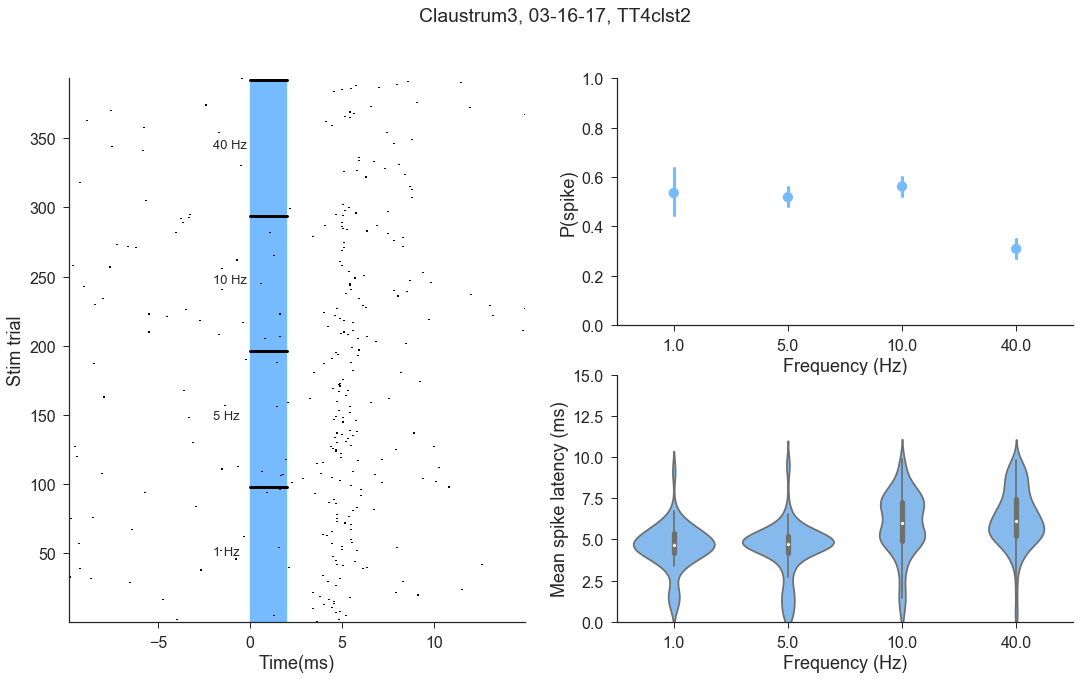

In [18]:
import seaborn as sns
sns.set_style("ticks")

mpl.close('all')
fig2 = mpl.figure(figsize=(18, 10))
fig2.suptitle(unit['mouse_name'] + ', ' +  unit['date'] + ', ' + unit['cluster_name'])
ax1 = mpl.subplot2grid((2,2), (0,0), rowspan=2, colspan=1)
ax2 = mpl.subplot2grid((2,2), (0,1), rowspan=1, colspan=1)
ax3 = mpl.subplot2grid((2,2), (1,1), rowspan=1, colspan=1)

data={}
total_stims = 0
for freq in frequencies:
    opto_stims = unit['grouped_opto_pulses'][freq]
    for stim_num in range(99):
        spike_inds = (unit['spikes'] >= opto_stims[stim_num]-0.01) & (unit['spikes'] < opto_stims[stim_num] + .015)
        spikes = (unit['spikes'][spike_inds] - opto_stims[stim_num])*1000
        ax1.vlines(spikes, total_stims + stim_num + .5, total_stims + stim_num + 1.3, linewidth = 2)
        x = total_stims+stim_num
    ax1.plot([0,stim_duration*1000], [total_stims+stim_num, total_stims+stim_num], color = 'k', linewidth = 3)
    ax1.text(-2, total_stims + stim_num/2, str(freq) + ' Hz', fontsize = 13),
    total_stims = total_stims + stim_num
    
    spikes = np.array([x[0] for x in unit['spikes']])
    idx = spikes.searchsorted(opto_stims, side = 'right')
    latencies = spikes[idx] - opto_stims
    data[freq] = latencies[0:]
    #data.append(latencies)
values = np.concatenate(list(data.values()))
labels = np.concatenate([[freq] * len(data[freq]) for freq in data.keys()])
data_df = pd.DataFrame([values, labels])
data_df=data_df.T
data_df.columns = ['values', 'labels']
data_df['values'] = data_df['values']*1000


data_df['reliability'] = 0 
light_evoked_spike = data_df['values'] <= 10
data_df.loc[light_evoked_spike, 'reliability'] = 1
sns.pointplot(x = 'labels', y = 'reliability', data = data_df, ax=ax2, join = False, color = 'xkcd:sky blue')


light_evoked_df = data_df[data_df['reliability'] == 1]
#sns.pointplot(data=data,ax=ax2, join = False)
#sns.boxplot(data=data,ax=ax2, showfliers = False)
sns.violinplot(x = 'labels', y = 'values', data = light_evoked_df, ax=ax3, color = 'xkcd:sky blue')

        
ax1.set_xlabel('Time(ms)', fontsize = 18)
ax1.set_ylabel('Stim trial', fontsize= 18)
ax1.autoscale(enable=True, tight=True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.add_patch(patches.Rectangle((0,0), stim_duration*1000, total_stims, color = 'xkcd:sky blue')) 

ax3.set_xlabel('Frequency (Hz)', fontsize = 18)
ax3.set_ylabel('Mean spike latency (ms)', fontsize = 18)
ax3.set_ylim(0,15)

ax2.set_xlabel('Frequency (Hz)',fontsize = 18)
ax2.set_ylabel('P(spike)',fontsize = 18)
ax2.set_ylim(0,1)

sns.despine();  

fig2

In [14]:
light_evoked_df

,values,labels,reliability


In [ ]:
unit['grouped_opto_pulses'][1][3] -unit['spikes'][unit['spikes']>unit['grouped_opto_pulses'][1][3]][0]

In [ ]:
unit['grouped_opto_pulses'][1][1]-unit['spikes'][unit['spikes']>4574.0420666666669][1]

In [ ]:
data_df

In [ ]:
    spike_latency = []
    for stim_num in range(len(opto_stims)):
        aligned_spikes = (unit['spikes'] - opto_stims[stim_num])
        first_spike = np.min(aligned_spikes[aligned_spikes > 0])
        spike_latency.append(spike_latency)
    data.append([spike_latency])

ax2.boxplot(data)
    